In [1]:
import kagglehub
import pandas as pd
import os
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score


C:\Users\hp\anaconda2\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:15: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


# Download and Load Dataset


In [2]:
# Download latest version
path = kagglehub.dataset_download("adrianmcmahon/imdb-india-movies")
print("Path to dataset files:", path)

# Find the CSV file in the directory
for file in os.listdir(path):
    if file.endswith(".csv"):
        csv_file_path = os.path.join(path, file)
        break

# Load the CSV file into a DataFrame with a specified encoding
df = pd.read_csv(csv_file_path, encoding='ISO-8859-1')


Path to dataset files: C:\Users\hp\.cache\kagglehub\datasets\adrianmcmahon\imdb-india-movies\versions\1


#  Initial Data Exploration

In [3]:
# Display the first few rows of the DataFrame
df.head()



,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,(2021),90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,(2010),105 min,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali


In [4]:
# Drop NaN values
df.dropna(inplace=True)
print(f"DataFrame shape after dropping NaN: {df.shape}")

DataFrame shape after dropping NaN: (5659, 10)


In [5]:
df.describe()


,Rating
count,5659.000000
mean,5.898533
std,1.381165
min,1.100000
25%,5.000000
50%,6.100000
75%,6.900000
max,10.000000


In [6]:
df.isnull().sum()


Name        0
Year        0
Duration    0
Genre       0
Rating      0
Votes       0
Director    0
Actor 1     0
Actor 2     0
Actor 3     0
dtype: int64

# Data Cleaning and Transformation


In [7]:
# Process 'Duration' column
df['Duration'] = df['Duration'].apply(lambda x: float(x.split()[0]) if isinstance(x, str) and x.strip().endswith("min") else x)

# Process genres
df['Genre'] = df['Genre'].astype(str)
genres_split = df['Genre'].str.split(',', expand=True)
genres_split.columns = ['Genre1', 'Genre2', 'Genre3']
df = pd.concat([df, genres_split], axis=1)

for col in ['Genre1', 'Genre2', 'Genre3', 'Director', 'Actor 1', 'Actor 2', 'Actor 3']:
    avg_rating = df.groupby(col)['Rating'].transform('mean')
    df[f'{col}_Average_Rating'] = avg_rating

# Function to convert votes
def clean_votes(vote):
    if pd.isnull(vote):
        return None
    
    vote = vote.replace(',', '').replace('$', '').strip()
    if 'M' in vote:
        return float(vote.replace('M', '')) * 1_000_000
    elif 'K' in vote:
        return float(vote.replace('K', '')) * 1_000
    else:
        try:
            return float(vote)
        except ValueError:
            return None

# Apply the function to the Votes column
df['Votes'] = df['Votes'].apply(clean_votes)
df['Votes'] = pd.to_numeric(df['Votes'], errors='coerce')

# Clean the 'Year' column to remove parentheses and convert to int
df['Year'] = df['Year'].str.replace(r'\D', '', regex=True).astype(int)

# Verify the conversion
print(df['Year'].dtype)
print(df[['Year']].head())





int32
   Year
1  2019
3  2019
5  1997
6  2005
8  2012


In [8]:
df.dtypes

Name                        object
Year                         int32
Duration                   float64
Genre                       object
Rating                     float64
Votes                      float64
Director                    object
Actor 1                     object
Actor 2                     object
Actor 3                     object
Genre1                      object
Genre2                      object
Genre3                      object
Genre1_Average_Rating      float64
Genre2_Average_Rating      float64
Genre3_Average_Rating      float64
Director_Average_Rating    float64
Actor 1_Average_Rating     float64
Actor 2_Average_Rating     float64
Actor 3_Average_Rating     float64
dtype: object

# EDA

In [9]:
# Year with the best average rating
best_year = df.groupby('Year')['Rating'].mean().idxmax()
best_rating = df.groupby('Year')['Rating'].mean().max()

print(f"The year with the best average rating is {best_year} with an average rating of {best_rating:.2f}.")


The year with the best average rating is 1952 with an average rating of 7.21.


Correlation between Duration and Rating: 0.00


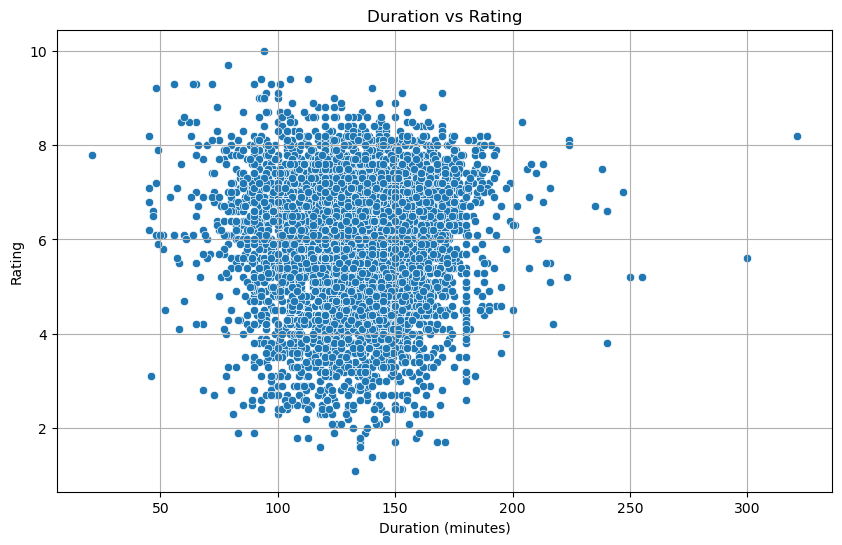

In [10]:
import seaborn as sns

# Correlation between Duration and Rating
correlation = df['Duration'].corr(df['Rating'])
print(f"Correlation between Duration and Rating: {correlation:.2f}")

# Visualize the relationship
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Duration', y='Rating', data=df)
plt.title('Duration vs Rating')
plt.xlabel('Duration (minutes)')
plt.ylabel('Rating')
plt.grid()
plt.show()


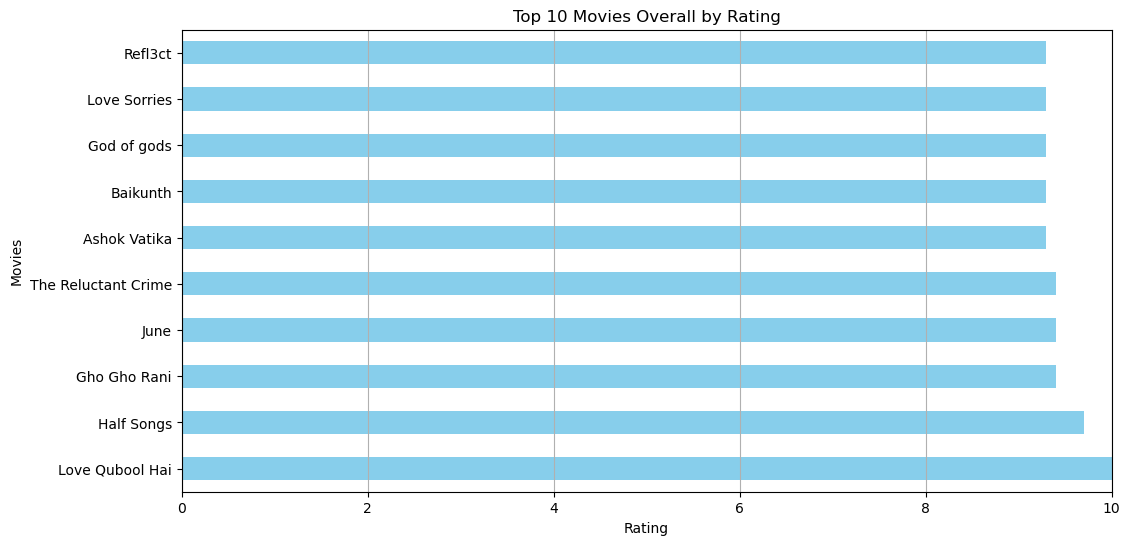

In [11]:
import matplotlib.pyplot as plt

# Top 10 movies overall by rating
top_10_overall = df.nlargest(10, 'Rating')[['Name', 'Rating']]
top_10_overall.set_index('Name', inplace=True)


# Create a bar graph for Top 10 Movies Overall
plt.figure(figsize=(12, 6))
top_10_overall['Rating'].plot(kind='barh', color='skyblue')
plt.title('Top 10 Movies Overall by Rating')
plt.xlabel('Rating')
plt.ylabel('Movies')
plt.xlim(0, 10)  # Assuming ratings are out of 10
plt.grid(axis='x')
plt.show()



In [12]:
# Top 10 movies per year
top_10_per_year = df.loc[df.groupby('Year')['Rating'].idxmax()][['Year', 'Name', 'Rating']]
top_10_per_year = top_10_per_year.nlargest(10, 'Rating')
print("\nTop 10 Movies per Year by Rating:")
print(top_10_per_year)


Top 10 Movies per Year by Rating:
       Year                                              Name  Rating
8339   2020                                   Love Qubool Hai    10.0
5410   2021                                        Half Songs     9.7
5077   2019                                      Gho Gho Rani     9.4
1314   2018                                      Ashok Vatika     9.3
6025   2007                                       I'm in Love     9.2
14071  2015   The Flip Side: A Truth That Could Not Reach You     9.2
10217  2011                                         Nirvana13     9.1
11841  2017                               Rediscovering India     9.0
8188   2008  Leaving Home: The Life and Music of Indian Ocean     8.9
4953   2016                         Gauru: Journey of Courage     8.8


In [13]:
# Define what you consider a "popular" movie (e.g., Rating > 7)
popular_movies = df[df['Rating'] > 7]

# Count the number of popular movies per year
popular_movies_count = popular_movies.groupby('Year').size()
print("Number of Popular Movies Released Each Year:")
print(popular_movies_count)


Number of Popular Movies Released Each Year:
Year
1934     1
1935     1
1936     1
1938     1
1940     4
        ..
2017    54
2018    63
2019    79
2020    43
2021    28
Length: 86, dtype: int64


In [14]:
# Overall count of votes and average rating
overall_votes_performance = df.groupby('Votes')['Rating'].mean().reset_index()
overall_votes_performance = overall_votes_performance.sort_values(by='Rating', ascending=False)

print("Overall Movies Performance by Votes and Ratings:")
print(overall_votes_performance.head(10))


Overall Movies Performance by Votes and Ratings:
        Votes  Rating
1124   2219.0     9.1
2011  83029.0     9.1
1055   1928.0     8.7
906    1417.0     8.6
931    1523.0     8.6
567     663.0     8.6
1618   7711.0     8.6
1840  18376.0     8.5
1852  19493.0     8.5
1761  13120.0     8.5


In [15]:

# Votes performance per year
votes_performance_year = df.groupby('Year').agg({'Votes': 'sum', 'Rating': 'mean'}).reset_index()
print("Votes Performance by Year:")
print(votes_performance_year)


Votes Performance by Year:
    Year     Votes    Rating
0   1931     118.0  5.750000
1   1932      12.0  6.000000
2   1933      12.0  6.200000
3   1934      17.0  5.600000
4   1935      89.0  5.700000
..   ...       ...       ...
86  2017  519172.0  6.012796
87  2018  881648.0  6.150495
88  2019  607647.0  6.265198
89  2020  814696.0  6.123571
90  2021  307855.0  6.522222

[91 rows x 3 columns]


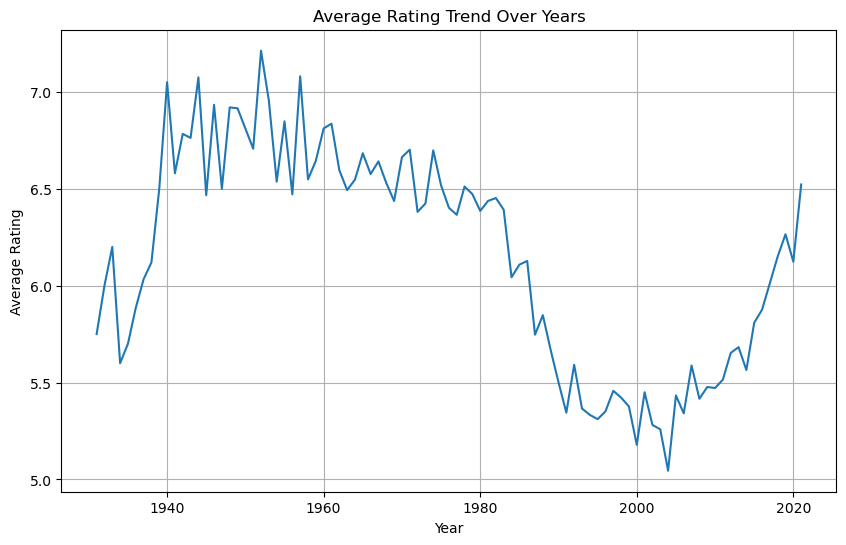

In [16]:
# Trend of average ratings over the years
avg_rating_trend = df.groupby('Year')['Rating'].mean()
plt.figure(figsize=(10, 6))
avg_rating_trend.plot(kind='line')
plt.title('Average Rating Trend Over Years')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.grid()
plt.show()


In [17]:
# Director with the most movies
most_movies_director = df['Director'].value_counts().idxmax()
most_movies_count = df['Director'].value_counts().max()

print(f"The director with the most movies is {most_movies_director} with {most_movies_count} movies.")


The director with the most movies is David Dhawan with 41 movies.


In [18]:
# Actor with the most appearances
most_movies_actor1 = df['Actor 1'].value_counts().idxmax()
most_movies_actor1_count = df['Actor 1'].value_counts().max()

most_movies_actor2 = df['Actor 2'].value_counts().idxmax()
most_movies_actor2_count = df['Actor 2'].value_counts().max()

most_movies_actor3 = df['Actor 3'].value_counts().idxmax()
most_movies_actor3_count = df['Actor 3'].value_counts().max()

print(f"Most appearances by Actor 1: {most_movies_actor1} ({most_movies_actor1_count})")
print(f"Most appearances by Actor 2: {most_movies_actor2} ({most_movies_actor2_count})")
print(f"Most appearances by Actor 3: {most_movies_actor3} ({most_movies_actor3_count})")


Most appearances by Actor 1: Amitabh Bachchan (104)
Most appearances by Actor 2: Rekha (52)
Most appearances by Actor 3: Pran (57)


# Create Binned Ratings

In [19]:
# Define bins and labels for ratings
bins = [0, 5, 7, 10]
labels = [0, 1, 2]

# Create a new column for binned ratings
df['Rating_Binned'] = pd.cut(df['Rating'], bins=bins, labels=labels, include_lowest=True)
print(df[['Rating', 'Rating_Binned']].head())


   Rating Rating_Binned
1     7.0             1
3     4.4             0
5     4.7             0
6     7.4             2
8     5.6             1


# Define Features and Target

In [20]:
# Define features (X) and target (y)
X = df.drop(['Rating', 'Name', 'Director','Genre', 'Actor 1', 'Actor 2', 'Actor 3', 'Genre1', 'Genre2', 'Genre3'], axis=1)
y = df['Rating']


# Train-Test Split

In [21]:
# Perform stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=df['Rating_Binned'], random_state=42)

# Check the shapes of the splits
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (4527, 11)
X_test shape: (1132, 11)
y_train shape: (4527,)
y_test shape: (1132,)


# Model Training and Evaluation

In [22]:
# Initialize the model
hist_rf_model = HistGradientBoostingRegressor(random_state=42)

# Train the model
hist_rf_model.fit(X_train, y_train)

# Make predictions
y_pred = hist_rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 0.1543201745814097


# Hyperparameter Tuning

In [23]:
# Define parameter grid
param_grid = {
    'max_iter': [100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'max_leaf_nodes': [20, 30, 40],
}

# Perform GridSearchCV
grid_search = GridSearchCV(HistGradientBoostingRegressor(random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Best parameters found: ", grid_search.best_params_)


Best parameters found:  {'learning_rate': 0.1, 'max_iter': 100, 'max_leaf_nodes': 20}


# Final Model Evaluation

In [24]:
# Best parameters
best_params = {'learning_rate': 0.1, 'max_iter': 100, 'max_leaf_nodes': 20}

# Initialize the model with the best parameters
model = HistGradientBoostingRegressor(**best_params, random_state=42)

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Mean Squared Error: 0.15220458074268262
R-squared: 0.9224661064366985


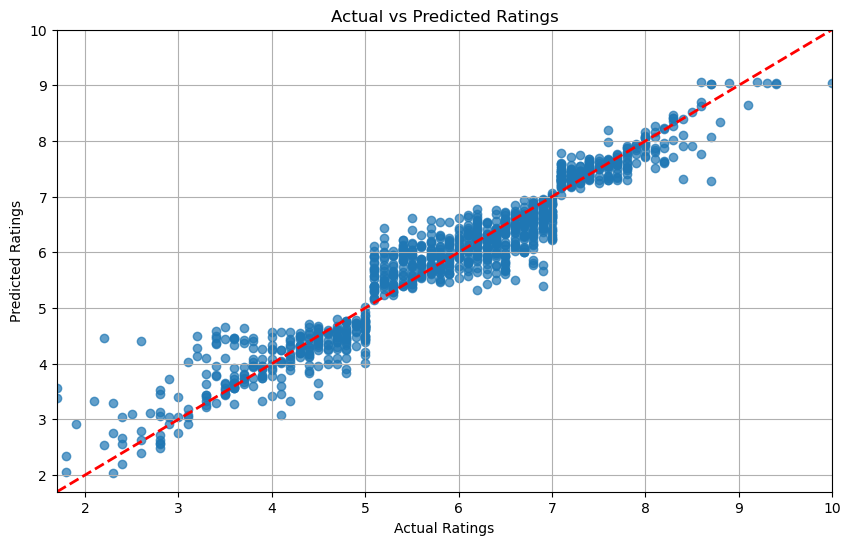

In [25]:
# Plotting Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # 45-degree line
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Actual vs Predicted Ratings')
plt.xlim(y_test.min(), y_test.max())
plt.ylim(y_test.min(), y_test.max())
plt.grid()
plt.show()
